In [484]:
from collections import Counter
from dateutil import parser
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [485]:
song_hist_path = 'data/song_history.csv'

In [486]:
songs = pd.read_csv(song_hist_path)

In [487]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 5 columns):
artists      229 non-null object
explicit     229 non-null bool
id           229 non-null object
name         229 non-null object
played_at    229 non-null object
dtypes: bool(1), object(4)
memory usage: 7.5+ KB


In [488]:
songs['played_at'] = songs['played_at'].apply(parser.parse)

(array([736971.5, 736972. , 736972.5, 736973. , 736973.5, 736974. ,
        736974.5]), <a list of 7 Text xticklabel objects>)

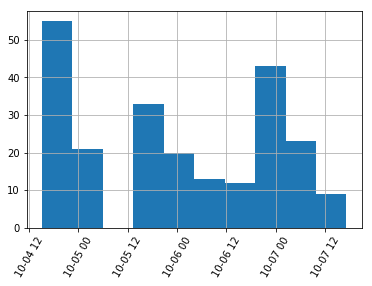

In [489]:
songs['played_at'].hist()
plt.xticks(rotation=60)

In [490]:
def timedelta_compare(delta, threshold):
    return delta.total_seconds() <= threshold


def group_by_time(times, interval=(60 * 10)):
    groups = [False]
    groups.extend([timedelta_compare(times[i] - times[i+1], interval) for i in range(len(times)-1)])
    groups.append(False) # get last idx as a group too
    return groups


def assign_groups(break_points):
    grps = {}
    old_bp = 0
    for g, bp in enumerate(break_points):
        grps.update({i: g for i in range(break_points[g-1], bp)})
        old_bp = bp
    return grps

In [491]:
break_points = [i for i,x in enumerate(group_by_time(songs.played_at)) if x==False]

song_groups = {idx: i for i, idx in enumerate(break_points)}

assigned_groups = assign_groups(break_points)

songs['group'] = -1
for idx, grp in assigned_groups.items():
    songs.at[idx, 'group']=grp

In [492]:
songs.groupby('group').count()

,artists,explicit,id,name,played_at
group,,,,,
1,18,18,18,18,18
2,2,2,2,2,2
3,3,3,3,3,3
4,23,23,23,23,23
5,1,1,1,1,1
6,1,1,1,1,1
7,14,14,14,14,14
8,1,1,1,1,1
9,1,1,1,1,1


In [493]:
song_counts = dict(Counter(songs.name))

## Make Graph

In [494]:
import networkx as nx
import numpy as np
import json

In [495]:
def minmax_scale(col):
    def _scale(x, cmin, cmax):
        return (x-cmax + cmin)/(cmax-cmin)
    cmin, cmax = col.min(), col.max()
    return (col-cmin)/(cmax-cmin)

In [496]:
songs_cartesian = pd.merge(songs, songs, on=['group'], how='outer', suffixes=['_to', '_from'])

songs_cartesian = songs_cartesian[songs_cartesian.played_at_from != songs_cartesian.played_at_to]

songs_cartesian['delta_s'] = songs_cartesian.apply(lambda r: np.abs(r['played_at_to'] - r['played_at_from']).total_seconds(), axis=1)

songs_cartesian = songs_cartesian.sort_values(['name_to', 'name_from']).drop_duplicates(subset=['group', 'delta_s'])

songs_cartesian['scaled_delta_s'] = minmax_scale(songs_cartesian.delta_s)

In [497]:
songs_ct_filt = songs_cartesian[(songs_cartesian.name_from.apply(lambda x: song_counts[x]>1)) & \
                                (songs_cartesian.name_to.apply(lambda x: song_counts[x]>1))]

In [498]:
songs_ct_filt.groupby('group').count()

,artists_to,explicit_to,id_to,name_to,played_at_to,artists_from,explicit_from,id_from,name_from,played_at_from,delta_s,scaled_delta_s
group,,,,,,,,,,,,
1,15,15,15,15,15,15,15,15,15,15,15,15
2,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1
4,78,78,78,78,78,78,78,78,78,78,78,78
7,28,28,28,28,28,28,28,28,28,28,28,28
10,10,10,10,10,10,10,10,10,10,10,10,10
12,45,45,45,45,45,45,45,45,45,45,45,45
13,15,15,15,15,15,15,15,15,15,15,15,15
14,136,136,136,136,136,136,136,136,136,136,136,136


In [499]:
def make_graph(df, counts=song_counts):
    incl_songs = set(list(df.name_from) + list(df.name_to))
    counts = {k:v for k, v in song_counts.items() if k in incl_songs}
    G = nx.MultiGraph()

    for song, count in counts.items():
        G.add_node(song, count=count)

    for song_pair in df[['name_to', 'name_from', 'group', 'scaled_delta_s']].to_dict(orient='index').values():
        G.add_edge(song_pair['name_to'], song_pair['name_from'], group=str(song_pair['group']), dist=str(song_pair['scaled_delta_s']))
    return G

In [500]:
G = make_graph(songs_ct_filt)

In [501]:
links = nx.node_link_data(G)['links']
nodes = {x['id']: x for x in nx.node_link_data(G)['nodes']}

In [502]:
json.dump({'nodes': nodes, 'links': links}, open('graphs/graph.json', 'w'))